In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os 
import copy
import pickle

import numpy as np 
from scipy import interpolate

import astropy.units as u
from astropy.table import Table, Column, join
from astropy.cosmology import FlatLambdaCDM

from scipy.stats import binned_statistic_2d
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt

In [2]:
sum_cat = Table.read('/Users/song/Dropbox/work/data/merian/s2n_cosmos_badseeing_all_psf_summary_copilot.fits')

print(sum_cat.colnames)

['visit', 'ccd', 'time_utc', 'alt_degree', 'az_degree', 'ha_degree', 'rot_degree', 't_exposure', 'airmass_1', 'temperature', 'air_pressure', 'humidity', 'n_obj', 'n_obj_use', 'n_sky', 'mag_3sig_obj', 'mag_5sig_obj', 'mag_10sig_obj', 'mag_3sig_sky', 'mag_5sig_sky', 'mag_10sig_sky', 'filename', 'extension', 'expnum', 'exptime', 'mjd_obs', 'airmass_2', 'racenter', 'deccenter', 'rabore', 'decbore', 'band', 'ebv', 'zeropoint', 'transparency', 'seeing', 'sky', 'expfactor', 'camera', 'dx', 'dy', 'nmatched', 'md5sum', 'bad_pixcnt', 'readtime', 'obstype', 'object', 'tileid', 'passnumber', 'tileebv', 'affine_x0', 'affine_y0', 'affine_dx', 'affine_dxx', 'affine_dxy', 'affine_dy', 'affine_dyx', 'affine_dyy', 'teff', 'GroupID', 'GroupSize']


In [3]:
sum_use = sum_cat[sum_cat['exptime'] >= 100.]

In [4]:
visit_list_uniq = list(np.unique(sum_use['visit']))

print(visit_list_uniq)

[971667, 971668, 971669, 971670, 971671, 971673, 971675, 971676, 971677, 971679, 971680, 971681, 971683, 971685, 971687, 971689, 971690, 971691, 971693, 971694, 971893, 971894, 971895, 971896, 971897, 971898, 971899, 971900, 971901, 971902, 971903, 971904, 971905, 971906, 971907, 971908, 971909, 971910, 971911, 971912, 972108, 972360, 972361, 972362, 972363, 972364, 972365, 972572, 972799, 972800, 973016, 973017, 973514, 973806, 973807, 973808, 973810, 974588, 974589]


In [5]:
mag_5sig_rel = []
for visit in visit_list_uniq:
    sum_visit = sum_use[sum_use['visit'] == visit]
    
    flag = ((sum_visit['ccd'] != b'N4 ') & (sum_visit['ccd'] != b'N5 ') & 
            (sum_visit['ccd'] != b'N6 ') & (sum_visit['ccd'] != b'N7 ') & 
            (sum_visit['ccd'] != b'S4 ') & (sum_visit['ccd'] != b'S5 ') & 
            (sum_visit['ccd'] != b'S6 ') & (sum_visit['ccd'] != b'S7 '))
    
    sum_visit_use = sum_visit[flag]
    
    print("# Visit: {:5d} <5sig>={:5.2f} mag   std={:5.3f} mag".format(
        visit, np.nanmedian(sum_visit_use['mag_5sig_obj']), np.nanstd(sum_visit_use['mag_5sig_obj'])))
    
    diff_list = list(sum_visit_use['mag_5sig_obj'] - np.nanmedian(sum_visit_use['mag_5sig_obj']))
    _ = [mag_5sig_rel.append(d) for d in diff_list]

# Visit: 971667 <5sig>=24.02 mag   std=0.057 mag
# Visit: 971668 <5sig>=24.06 mag   std=0.060 mag
# Visit: 971669 <5sig>=23.90 mag   std=0.059 mag
# Visit: 971670 <5sig>=24.06 mag   std=0.058 mag
# Visit: 971671 <5sig>=24.07 mag   std=0.056 mag
# Visit: 971673 <5sig>=24.11 mag   std=0.061 mag
# Visit: 971675 <5sig>=24.07 mag   std=0.061 mag
# Visit: 971676 <5sig>=24.02 mag   std=0.058 mag
# Visit: 971677 <5sig>=24.21 mag   std=0.066 mag
# Visit: 971679 <5sig>=24.22 mag   std=0.054 mag
# Visit: 971680 <5sig>=24.20 mag   std=0.065 mag
# Visit: 971681 <5sig>=24.13 mag   std=0.063 mag
# Visit: 971683 <5sig>=24.05 mag   std=0.056 mag
# Visit: 971685 <5sig>=24.01 mag   std=0.080 mag
# Visit: 971687 <5sig>=24.05 mag   std=0.074 mag
# Visit: 971689 <5sig>=24.03 mag   std=0.048 mag
# Visit: 971690 <5sig>=23.91 mag   std=0.045 mag
# Visit: 971691 <5sig>=23.94 mag   std=0.052 mag
# Visit: 971693 <5sig>=23.93 mag   std=0.051 mag
# Visit: 971694 <5sig>=23.99 mag   std=0.062 mag
# Visit: 971893 <5si

In [6]:
np.nanstd(np.asarray(mag_5sig_rel))

0.05768997514947796

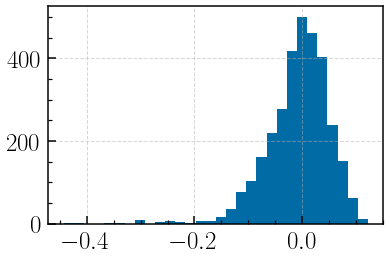

In [7]:
_ = plt.hist(mag_5sig_rel, bins=30)

In [8]:
exp_test = sum_use[sum_use['visit'] == 971667]

exp_test[exp_test['mag_5sig_obj'] <= 23.85]['ccd']

N30
N4
N5
N6
N7
S4
S5
S6
S7


In [9]:
ccd_list_uniq = list(np.unique(sum_use['ccd']))

In [10]:
ccd_index = [ccd_list_uniq.index(ccd) + 1 for ccd in sum_use['ccd']]

sum_use['ccd_index'] = ccd_index

Text(55, 24.15, '${\\rm COSMOS} + {\\rm Bad\\ Seeing}$')

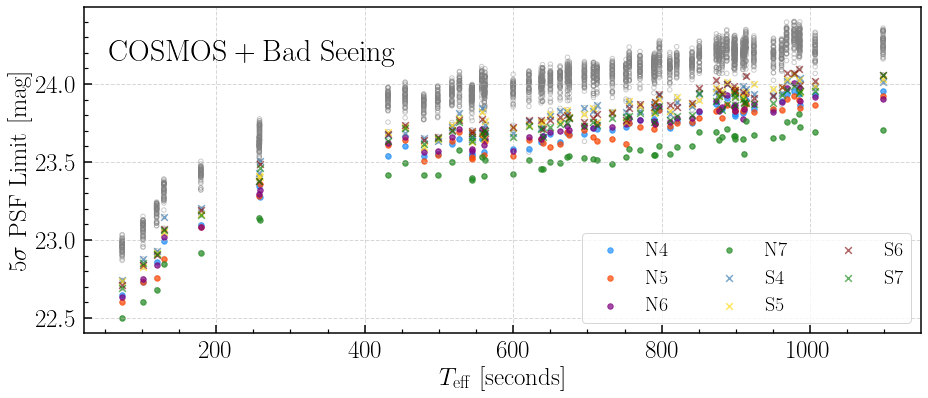

In [20]:
plt.figure(figsize=(15, 6))

plt.scatter(sum_use['teff'], sum_use['mag_5sig_obj'], edgecolor='grey', facecolor='none', s=20, alpha=0.4)

mask_n4 = sum_use['ccd'] == b'N4 '
plt.scatter(sum_use['teff'][mask_n4], sum_use['mag_5sig_obj'][mask_n4], s=30, c='dodgerblue', alpha=0.7, label=r'\rm N4')

mask_n5 = sum_use['ccd'] == b'N5 '
plt.scatter(sum_use['teff'][mask_n5], sum_use['mag_5sig_obj'][mask_n5], s=30, c='orangered', alpha=0.7, label=r'\rm N5')

mask_n6 = sum_use['ccd'] == b'N6 '
plt.scatter(sum_use['teff'][mask_n6], sum_use['mag_5sig_obj'][mask_n6], s=30, c='purple', alpha=0.7, label=r'\rm N6')

mask_n7 = sum_use['ccd'] == b'N7 '
plt.scatter(sum_use['teff'][mask_n7], sum_use['mag_5sig_obj'][mask_n7], s=30, c='forestgreen', alpha=0.7, label=r'\rm N7')

mask_s4 = sum_use['ccd'] == b'S4 '
plt.scatter(sum_use['teff'][mask_s4], sum_use['mag_5sig_obj'][mask_s4], s=45, c='steelblue', marker='x', alpha=0.7, label=r'\rm S4')

mask_s5 = sum_use['ccd'] == b'S5 '
plt.scatter(sum_use['teff'][mask_s5], sum_use['mag_5sig_obj'][mask_s5], s=45, c='gold', marker='x', alpha=0.6, label=r'\rm S5')

mask_s6 = sum_use['ccd'] == b'S6 '
plt.scatter(sum_use['teff'][mask_s6], sum_use['mag_5sig_obj'][mask_s6], s=45, c='maroon', marker='x', alpha=0.6, label=r'\rm S6')

mask_s7 = sum_use['ccd'] == b'S7 '
plt.scatter(sum_use['teff'][mask_s7], sum_use['mag_5sig_obj'][mask_s7], s=45, c='green', marker='x', alpha=0.6, label=r'\rm S7')

plt.xlabel(r'$T_{\rm eff}\ [\rm seconds]$', fontsize=25)
plt.ylabel(r'$5\sigma\ \rm PSF\ Limit\ [mag]$', fontsize=25)

plt.legend(loc='best', fontsize=20, ncol=3)

plt.text(55, 24.15, r'${\rm COSMOS} + {\rm Bad\ Seeing}$', fontsize=30)

#_ = plt.xlim(0.71, 1.25)

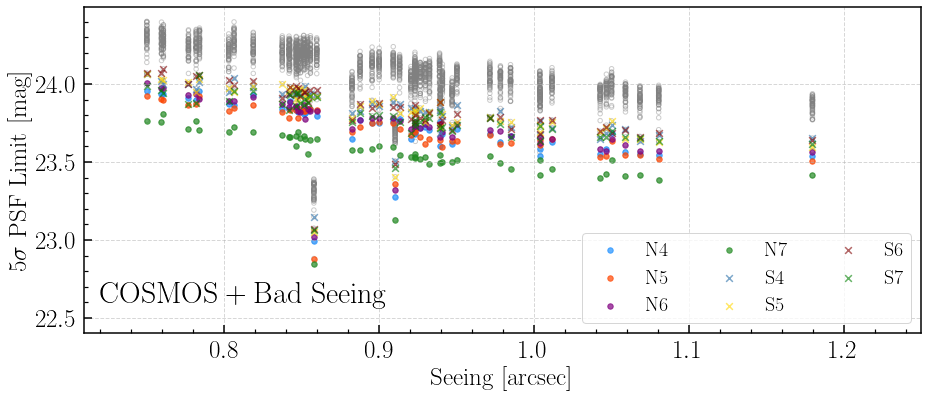

In [23]:
plt.figure(figsize=(15, 6))

plt.scatter(sum_use['seeing'], sum_use['mag_5sig_obj'], edgecolor='grey', facecolor='none', s=20, alpha=0.4)

mask_n4 = sum_use['ccd'] == b'N4 '
plt.scatter(sum_use['seeing'][mask_n4], sum_use['mag_5sig_obj'][mask_n4], s=30, c='dodgerblue', alpha=0.7, label=r'\rm N4')

mask_n5 = sum_use['ccd'] == b'N5 '
plt.scatter(sum_use['seeing'][mask_n5], sum_use['mag_5sig_obj'][mask_n5], s=30, c='orangered', alpha=0.7, label=r'\rm N5')

mask_n6 = sum_use['ccd'] == b'N6 '
plt.scatter(sum_use['seeing'][mask_n6], sum_use['mag_5sig_obj'][mask_n6], s=30, c='purple', alpha=0.7, label=r'\rm N6')

mask_n7 = sum_use['ccd'] == b'N7 '
plt.scatter(sum_use['seeing'][mask_n7], sum_use['mag_5sig_obj'][mask_n7], s=30, c='forestgreen', alpha=0.7, label=r'\rm N7')

mask_s4 = sum_use['ccd'] == b'S4 '
plt.scatter(sum_use['seeing'][mask_s4], sum_use['mag_5sig_obj'][mask_s4], s=45, c='steelblue', marker='x', alpha=0.7, label=r'\rm S4')

mask_s5 = sum_use['ccd'] == b'S5 '
plt.scatter(sum_use['seeing'][mask_s5], sum_use['mag_5sig_obj'][mask_s5], s=45, c='gold', marker='x', alpha=0.6, label=r'\rm S5')

mask_s6 = sum_use['ccd'] == b'S6 '
plt.scatter(sum_use['seeing'][mask_s6], sum_use['mag_5sig_obj'][mask_s6], s=45, c='maroon', marker='x', alpha=0.6, label=r'\rm S6')

mask_s7 = sum_use['ccd'] == b'S7 '
plt.scatter(sum_use['seeing'][mask_s7], sum_use['mag_5sig_obj'][mask_s7], s=45, c='green', marker='x', alpha=0.6, label=r'\rm S7')

plt.xlabel(r'$\rm Seeing\ [arcsec]$', fontsize=25)
plt.ylabel(r'$5\sigma\ \rm PSF\ Limit\ [mag]$', fontsize=25)

plt.legend(loc='best', fontsize=20, ncol=3)

plt.text(0.72, 22.6, r'${\rm COSMOS} + {\rm Bad\ Seeing}$', fontsize=30)

_ = plt.xlim(0.71, 1.25)

Text(0.72, 22.6, '${\\rm COSMOS} + {\\rm Bad\\ transparency}$')

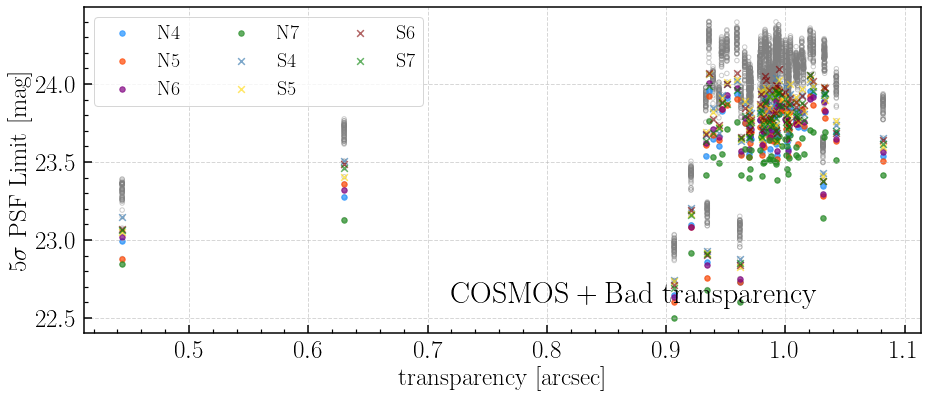

In [32]:
plt.figure(figsize=(15, 6))

plt.scatter(sum_use['transparency'], sum_use['mag_5sig_obj'], edgecolor='grey', facecolor='none', s=20, alpha=0.4)

mask_n4 = sum_use['ccd'] == b'N4 '
plt.scatter(sum_use['transparency'][mask_n4], sum_use['mag_5sig_obj'][mask_n4], s=30, c='dodgerblue', alpha=0.7, label=r'\rm N4')

mask_n5 = sum_use['ccd'] == b'N5 '
plt.scatter(sum_use['transparency'][mask_n5], sum_use['mag_5sig_obj'][mask_n5], s=30, c='orangered', alpha=0.7, label=r'\rm N5')

mask_n6 = sum_use['ccd'] == b'N6 '
plt.scatter(sum_use['transparency'][mask_n6], sum_use['mag_5sig_obj'][mask_n6], s=30, c='purple', alpha=0.7, label=r'\rm N6')

mask_n7 = sum_use['ccd'] == b'N7 '
plt.scatter(sum_use['transparency'][mask_n7], sum_use['mag_5sig_obj'][mask_n7], s=30, c='forestgreen', alpha=0.7, label=r'\rm N7')

mask_s4 = sum_use['ccd'] == b'S4 '
plt.scatter(sum_use['transparency'][mask_s4], sum_use['mag_5sig_obj'][mask_s4], s=45, c='steelblue', marker='x', alpha=0.7, label=r'\rm S4')

mask_s5 = sum_use['ccd'] == b'S5 '
plt.scatter(sum_use['transparency'][mask_s5], sum_use['mag_5sig_obj'][mask_s5], s=45, c='gold', marker='x', alpha=0.6, label=r'\rm S5')

mask_s6 = sum_use['ccd'] == b'S6 '
plt.scatter(sum_use['transparency'][mask_s6], sum_use['mag_5sig_obj'][mask_s6], s=45, c='maroon', marker='x', alpha=0.6, label=r'\rm S6')

mask_s7 = sum_use['ccd'] == b'S7 '
plt.scatter(sum_use['transparency'][mask_s7], sum_use['mag_5sig_obj'][mask_s7], s=45, c='green', marker='x', alpha=0.6, label=r'\rm S7')

plt.xlabel(r'$\rm transparency\ [arcsec]$', fontsize=25)
plt.ylabel(r'$5\sigma\ \rm PSF\ Limit\ [mag]$', fontsize=25)

plt.legend(loc='best', fontsize=20, ncol=3)

plt.text(0.72, 22.6, r'${\rm COSMOS} + {\rm Bad\ transparency}$', fontsize=30)

#_ = plt.xlim(0.71, 1.25)

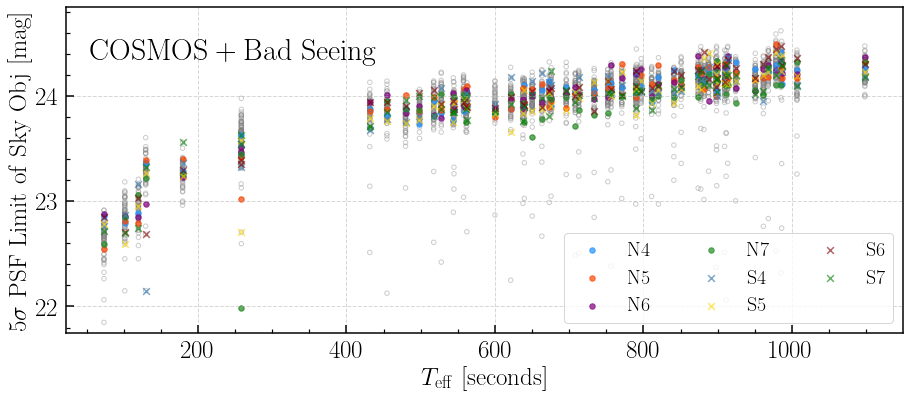

In [29]:
plt.figure(figsize=(15, 6))

plt.scatter(sum_use['teff'], sum_use['mag_5sig_sky'], edgecolor='grey', facecolor='none', s=20, alpha=0.4)

mask_n4 = sum_use['ccd'] == b'N4 '
plt.scatter(sum_use['teff'][mask_n4], sum_use['mag_5sig_sky'][mask_n4], s=30, c='dodgerblue', alpha=0.7, label=r'\rm N4')

mask_n5 = sum_use['ccd'] == b'N5 '
plt.scatter(sum_use['teff'][mask_n5], sum_use['mag_5sig_sky'][mask_n5], s=30, c='orangered', alpha=0.7, label=r'\rm N5')

mask_n6 = sum_use['ccd'] == b'N6 '
plt.scatter(sum_use['teff'][mask_n6], sum_use['mag_5sig_sky'][mask_n6], s=30, c='purple', alpha=0.7, label=r'\rm N6')

mask_n7 = sum_use['ccd'] == b'N7 '
plt.scatter(sum_use['teff'][mask_n7], sum_use['mag_5sig_sky'][mask_n7], s=30, c='forestgreen', alpha=0.7, label=r'\rm N7')

mask_s4 = sum_use['ccd'] == b'S4 '
plt.scatter(sum_use['teff'][mask_s4], sum_use['mag_5sig_sky'][mask_s4], s=45, c='steelblue', marker='x', alpha=0.7, label=r'\rm S4')

mask_s5 = sum_use['ccd'] == b'S5 '
plt.scatter(sum_use['teff'][mask_s5], sum_use['mag_5sig_sky'][mask_s5], s=45, c='gold', marker='x', alpha=0.6, label=r'\rm S5')

mask_s6 = sum_use['ccd'] == b'S6 '
plt.scatter(sum_use['teff'][mask_s6], sum_use['mag_5sig_sky'][mask_s6], s=45, c='maroon', marker='x', alpha=0.6, label=r'\rm S6')

mask_s7 = sum_use['ccd'] == b'S7 '
plt.scatter(sum_use['teff'][mask_s7], sum_use['mag_5sig_sky'][mask_s7], s=45, c='green', marker='x', alpha=0.6, label=r'\rm S7')

plt.xlabel(r'$T_{\rm eff}\ [\rm seconds]$', fontsize=25)
plt.ylabel(r'$5\sigma\ \rm PSF\ Limit\ of\ Sky\ Obj\ [mag]$', fontsize=25)

plt.legend(loc='best', fontsize=20, ncol=3)

plt.text(55, 24.35, r'${\rm COSMOS} + {\rm Bad\ Seeing}$', fontsize=30)

_ = plt.ylim(21.75, 24.85)